In [1]:
import sisl
import pandas as pd
import csv
import ast

from pathlib import Path
from tqdm import tqdm

# Read the dataset using SISL
path= Path('../dataset')

# Get all subdirectories (atom types)
n_atoms_paths = list(path.glob('*/'))

# Then all structures
i=0
structure_paths = [list(n_atoms_paths[i].glob('*/')) for i in range(len(n_atoms_paths))]
structure_paths = [item for sublist in structure_paths for item in sublist]

# Create Padnas DataFrame
columns = ["n_atoms", "atomic_number", "atomic_symbol", "atomic_positions", "lattice_nsc", "lattice_origin", "lattice_vectors", "boundary_condition"]
df = pd.DataFrame(columns=columns)
for structure in tqdm(structure_paths):
    file = sisl.get_sile(structure / "aiida.HSX")
    geometry = file.read_geometry()
    lattice_vectors = geometry.lattice

    # Get atom symbols
    atomic_symbols = []
    for atom in geometry.atoms:
        atomic_symbols.append(atom.symbol)

    row_dict = {
        "n_atoms": len(geometry),
        "atomic_number": geometry.atoms.Z,
        "atomic_symbol": atomic_symbols,
        "atomic_positions": geometry.xyz,
        "lattice_nsc": lattice_vectors.nsc,
        "lattice_origin": lattice_vectors.origin,
        "lattice_vectors": lattice_vectors.cell,
        "boundary_condition": lattice_vectors.boundary_condition
    }

    df = pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)
    
df.to_pickle("dataset.pkl")

def flatten(xss):
    return [x for xs in xss for x in xs]

100%|██████████| 1311/1311 [00:01<00:00, 686.21it/s]


In [2]:
# Read the dataset back
df = pd.read_pickle("dataset.pkl")
df.tail()

,n_atoms,atomic_number,atomic_symbol,atomic_positions,lattice_nsc,lattice_origin,lattice_vectors,boundary_condition
1306,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [3.2873668683...","[5, 5, 7]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1307,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.2881431...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1308,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [1.938954614,...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1309,3,"[5, 6, 7]","[B, C, N]","[[3.3844585986999998, 0.0, 0.0], [2.3964413432...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"
1310,3,"[7, 7, 6]","[N, N, C]","[[2.9851477079, 0.6391782245, 0.0], [0.3007791...","[5, 5, 5]","[0.0, 0.0, 0.0]","[[3.5999899999999996, 0.0, 0.0], [0.0, 3.59998...","[[2, 2], [2, 2], [2, 2]]"


In [3]:
# Print some stats.

# Unique atom types
unique_atom_types = []
for row in df["atomic_number"]:
    for atom_type in row:
        if atom_type not in unique_atom_types:
            unique_atom_types.append(atom_type)

# Unique atom symbols
unique_atom_symbols = []
for row in df["atomic_symbol"]:
    for atom_type in row:
        if atom_type not in unique_atom_symbols:
            unique_atom_symbols.append(atom_type)

print(f"Analyzed {len(df)} elements. Found:")
print(unique_atom_types)
print(unique_atom_symbols)

Analyzed 1311 elements. Found:
[7, 6, 5]
['N', 'C', 'B']


There are some carbons. How many of them?

In [4]:
n_carbon = df["atomic_number"].apply(lambda x: 6 in x).sum()
print(f"There are {n_carbon}/{len(df)} samples with Carbon atoms.")

There are 682/1311 samples with Carbon atoms.


This is more than half the dataset. Not negligible.

What is the distribution of the carbon atoms?

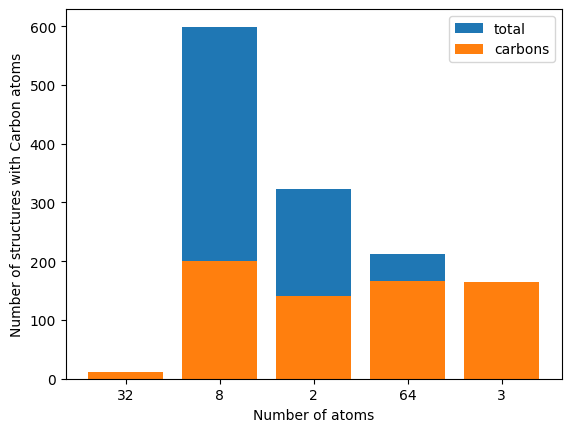

In [5]:
import matplotlib.pyplot as plt

n_atoms = df["n_atoms"].drop_duplicates()
counts = [df[df["n_atoms"] == i]["atomic_number"].apply(lambda x: 6 in x).sum() for i in n_atoms.to_list()]
x_labels = [str(i) for i in n_atoms.to_list()]

totals = [(df["n_atoms"] == i).sum() for i in n_atoms.to_list()]
plt.bar(x_labels, totals, label="total")
plt.bar(x_labels, counts, label="carbons")
plt.xlabel("Number of atoms")
plt.ylabel("Number of structures with Carbon atoms")
plt.legend()


In [6]:
# Let's try to exclude the carbons

parent_path = Path('../dataset')
n_atoms_paths = list(parent_path.glob('*/'))

paths = []
for n_atoms_path in n_atoms_paths:
    structure_paths = list(n_atoms_path.glob('*/'))

    structure_paths_nocarbon = structure_paths
    for structure_path in structure_paths:
        file = sisl.get_sile(structure_path / "aiida.fdf")
        geometry = file.read_geometry()
        zs = geometry.atoms.Z
        if 6 in zs:
            # Exclude this structure
            exclude = structure_path
            structure_paths_nocarbon = [x for x in structure_paths_nocarbon if x != exclude]


    paths.append(structure_paths_nocarbon)
paths = flatten(paths)

In [7]:
paths

[PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/82b3-4886-4447-b723-43a3ec6aa15c'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/d8c7-b0b4-4d41-895a-c014cdbd8416'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/cca5-7a6f-4d1a-9d8d-9db99d3b9ad9'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/807c-f894-4054-8ea4-da19dab86b43'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/e3fd-ba43-41c3-b53f-997c4a89dbfb'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/b05a-2bc5-4f47-8c55-03787b943376'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/e65d-4965-49b8-b158-22b21b6b6000'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/d972-1e26-4112-a6f0-7e806bc1c05c'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/f980-0604-4608-b493-c98c4b11a3b8'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/b10c-59df-431c-ae6c-b40c0eee9cb9'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/7f49-aa43-4b92-a2b2-a3bf11e36f26'),
 PosixPath('../dataset/SHARE_OUTPUTS_8_ATOMS/206b-84a4-448e-9bff-c353efe48997'),
 PosixPath('../dataset/SHARE

100%|██████████| 629/629 [00:00<00:00, 767.77it/s]


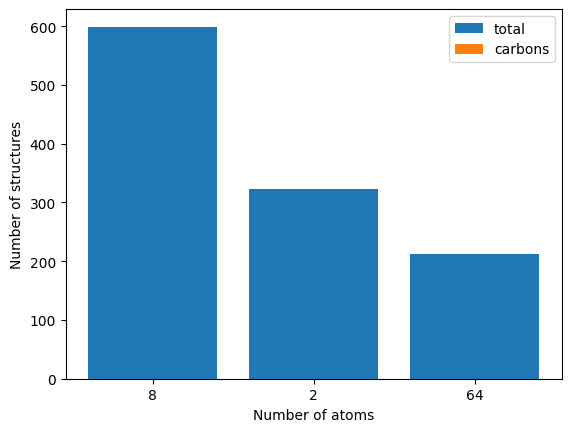

In [8]:
df_nocarbon = pd.DataFrame(columns=["n_atoms", "atomic_number"])
for path in tqdm(paths):
    file = sisl.get_sile(path / "aiida.HSX")
    geometry = file.read_geometry()
    lattice_vectors = geometry.lattice


    row_dict = {
        "n_atoms": len(geometry.atoms.Z),
        "atomic_number": geometry.atoms.Z,
    }

    df_nocarbon = pd.concat([df_nocarbon, pd.DataFrame([row_dict])], ignore_index=True)

import matplotlib.pyplot as plt

n_atoms = df_nocarbon["n_atoms"].drop_duplicates()
counts = [df_nocarbon[df_nocarbon["n_atoms"] == i]["atomic_number"].apply(lambda x: 6 in x).sum() for i in n_atoms.to_list()]
x_labels = [str(i) for i in n_atoms.to_list()]

totals = [(df["n_atoms"] == i).sum() for i in n_atoms.to_list()]
plt.bar(x_labels, totals, label="total")
plt.bar(x_labels, counts, label="carbons")
plt.xlabel("Number of atoms")
plt.ylabel("Number of structures")
plt.legend()

In [9]:
# Por qué siguen habiendo carbons? --> Ya no! :D
for i, path in tqdm(enumerate(paths)):
    file = sisl.get_sile(path / "aiida.HSX")
    geometry = file.read_geometry()
    if 6 in geometry.atoms.Z:
        print(f"Found a Carbon in path {i}")
        break
print("Finished loop")

629it [00:00, 943.97it/s] 

Finished loop


In [10]:
# Let's save those paths with no carbons.

# Get unique X_ATOMS
unique_x_atoms = []
for path in paths:
    x_atoms = path.parts[-2]
    if x_atoms not in unique_x_atoms:
        unique_x_atoms.append(x_atoms)
    
print(unique_x_atoms)

# Create children folders
parent_dir = Path("../dataset_nocarbon")
children_dirs = [parent_dir / unique_x_atoms_i for unique_x_atoms_i in unique_x_atoms]
for child_dir in children_dirs:
    child_dir.mkdir(exist_ok=True, parents=True)

# Create a list with as many lists as elements in unique_x_atoms
nocarbon_structures = [[] for _ in children_dirs]

# Classify the sturctures
for path in paths:
    for i, child_dir in enumerate(children_dirs):
        if child_dir.parts[-1] == path.parts[-2]:
            nocarbon_structures[i].append(path.parts[-1])
    
print(nocarbon_structures)

# Save them in their respective folder
for i, structures in enumerate(nocarbon_structures):
    filepath = children_dirs[i] / "structures.txt"
    with open(filepath, "w") as f:
        f.write("\n".join(structures))

print("Dataset saved!")
    

['SHARE_OUTPUTS_8_ATOMS', 'SHARE_OUTPUTS_2_ATOMS', 'SHARE_OUTPUTS_64_ATOMS']
[['82b3-4886-4447-b723-43a3ec6aa15c', 'd8c7-b0b4-4d41-895a-c014cdbd8416', 'cca5-7a6f-4d1a-9d8d-9db99d3b9ad9', '807c-f894-4054-8ea4-da19dab86b43', 'e3fd-ba43-41c3-b53f-997c4a89dbfb', 'b05a-2bc5-4f47-8c55-03787b943376', 'e65d-4965-49b8-b158-22b21b6b6000', 'd972-1e26-4112-a6f0-7e806bc1c05c', 'f980-0604-4608-b493-c98c4b11a3b8', 'b10c-59df-431c-ae6c-b40c0eee9cb9', '7f49-aa43-4b92-a2b2-a3bf11e36f26', '206b-84a4-448e-9bff-c353efe48997', '38b8-796c-40db-b82c-6089f2f40533', '2a68-331d-4fd7-814e-50a66d1f7fb3', '886e-5f60-41f0-8f65-42bb97fd5902', '1c41-4a17-40e0-9257-79aa2f4ddff5', 'deb2-d742-4fd8-be83-cc54ac6fb197', '94f2-cf36-421c-b6bb-9bec3cfb4e9e', 'e6ff-0ee3-4e51-a37a-6833377a357a', '4ed6-914e-4aa3-923a-53c873f0cc31', 'aa78-859c-4de1-92a2-39441a057b29', 'fa25-6194-4dc3-9999-0534970004d1', '0b9e-8905-4d8f-aee8-92b8c892c484', 'b2fa-0169-4f14-92df-dbe1d9580be4', 'a19c-b380-4924-8cf3-42160a16b896', '3cdc-77cd-4685-860f-

In [11]:
#Play with strings
[int(Path(p).stem.split('_')[2]) for p in unique_x_atoms]

[8, 2, 64]

# Removing the B-B and N-N bonds

In [16]:
def write_structures_paths(structures_paths, filepath):
    with open(filepath, "w") as f:
        f.write("\n".join(structures_paths))

def read_structures_paths(filepath):
    with open(filepath, "r") as f:
        return f.read().splitlines()

In [20]:
# Load the nocarbon dataset:
# === List of paths to all structures ===
exclude_carbons = True
use_only = None


true_dataset_folder = Path('../dataset')
paths = []
if exclude_carbons:
    pointers_folder = Path('../dataset_nocarbon')

    # Use only determined subset of the dataset
    if use_only is not None:
        x_atoms_paths = [pointers_folder / f"SHARE_OUTPUTS_{n}" for n in use_only]
    else:
        x_atoms_paths = list(pointers_folder.glob('*/'))

    # Get all the structures
    filepath = "structures.txt"
    structures_paths = [[] for _ in x_atoms_paths]
    for i, x_atoms_path in enumerate(x_atoms_paths):
        structures = read_structures_paths(str(x_atoms_path / filepath))
        for structure in structures:
            structures_paths[i].append(x_atoms_path.parts[-1] +"/"+ structure)

    # Now we join them with the true parent folder
    for structures in structures_paths:
        for structure in structures:
            true_path = true_dataset_folder / structure
            paths.append(true_path)
        
else:  
    # Join all structures in the paths variable
    n_atoms_paths = list(true_dataset_folder.glob('*/'))
    for n_atoms_path in n_atoms_paths:
        structure_paths = list(n_atoms_path.glob('*/')) 
        for structure_path in structure_paths:
            paths.append(structure_path)

In [ ]:
# Now we have to use sisl to read each structure and remove those B-B, N-N
for path in paths:
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    # ! Paso

# Where is the perfect crystal?

In [12]:
# === List of paths to all structures ===
import random
import yaml
from pathlib import Path
import sisl

def load_config(path="../config.yaml"):
    with open(path, "r") as f:
        return yaml.safe_load(f)
    
def flatten(xss):
    return [x for xs in xss for x in xs]


parent_path = Path('../dataset')
n_atoms_paths = list(parent_path.glob('*/'))
paths = []
for n_atoms_path in n_atoms_paths:
    structure_paths = list(n_atoms_path.glob('*/'))
    paths.append(structure_paths)
paths = flatten(paths)

random.seed(42)
random.shuffle(paths)

# Search the crystal with no carbon atoms
count = 0
for path in paths:
    file = sisl.get_sile(path / "aiida.fdf")
    geometry = file.read_geometry()
    if 6 not in geometry.atoms.Z and len(geometry.atoms.Z) == 8:
        print(f"Found a structure with no Carbon atoms: {path}")
        count += 1


print(f"Found {count} structures with no Carbon atoms.")

Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/907c-7487-46bd-8ad3-65b031f7f12b
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/74f6-ada8-4fcd-b69f-4ca3b0ddc30e
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/e84c-005c-4672-8d63-61876b569f15
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/8bfa-ca36-41f1-a041-14ad17494d59
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/5721-4d12-41f2-9f31-f7ee4fcf1096
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/807c-f894-4054-8ea4-da19dab86b43
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/4afc-f1fa-44f8-b159-50cdb0c2020b
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/8fb0-5187-4844-ab5b-f005e5a16194
Found a structure with no Carbon atoms: ../dataset/SHARE_OUTPUTS_8_ATOMS/085c-aa27-45ef-b057-4291c5609360
Found a structure with no Carbon atoms: ../dat

In [13]:
# Ok. There are several structures which are crystals with no Carbon atoms. Then, what is different in these structures?
paths = [
    Path("../dataset/SHARE_OUTPUTS_8_ATOMS/907c-7487-46bd-8ad3-65b031f7f12b"),
    Path("../dataset/SHARE_OUTPUTS_8_ATOMS/74f6-ada8-4fcd-b69f-4ca3b0ddc30e")
]

for i, path in enumerate(paths):
    print(f"Analyzing structure", i+1)
    file = sisl.get_sile(path / "aiida.fdf")
    file.plot.geometry(axes="xz")

Analyzing structure 1
Analyzing structure 2


In [14]:
file = sisl.get_sile(paths[0] / "aiida.fdf")
file.plot.geometry(axes="xyz")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

INFO	Task(Task-2) nodify.node.140418257975728:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418257966128:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256230576:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418257971120:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256230384:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256230192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418257966128:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256230576:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418257971120:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256230384:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256230192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418257966128:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.nod

In [15]:
file = sisl.get_sile(paths[1] / "aiida.fdf")
file.plot.geometry(axes="xyz")

INFO	Task(Task-2) nodify.node.140418141863184:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.

INFO	Task(Task-2) nodify.node.140418142707184:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142862416:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142855936:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141857376:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418144270144:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141852624:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418144270672:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142736208:node.py:get()- Evaluated because inputs changed.
INFO	Task(Task-2) nodify.node.140418142855936:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141857376:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418144270144:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

INFO	Task(Task-2) nodify.node.140418141863184:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418141906192:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142855792:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142850272:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418256693024:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.node.140418142859152:node.py:get()- No need to evaluate
INFO	Task(Task-2) nodify.nod